# Adjusting for class imbalance

Naive Bayes classifier makes prediction using the class prior it learned from the ratio of classes in the training data. Large discrepancy of class ratios between training and validation sets leads to the inaccurate estimation of class prior which decrease the predictive performance of naive Bayes classifier.

## Oversampling the minority class

Oversampling balances the dataset by increasing the size of the minority class. A balanced new dataset can then be retrieved for further modelling

In [1]:
import pandas as pd 
import numpy as np 
import scipy.sparse
import pickle
import os
import warnings
from eval_funcs import *
warnings.filterwarnings("ignore")

In [2]:
wikihow = pd.read_csv('./datasets/wikihow_sep_features.csv')
wikihow_subset = pd.read_csv('./datasets/wikihow_sep_subset.csv')

In [3]:
#Picking 3 random new articles text_id = 10115, 146523,53935 
text_1_df = wikihow[wikihow['text_id'] == 10115]
text_2_df = wikihow[wikihow['text_id'] == 146523]
text_3_df = wikihow[wikihow['text_id'] == 53935]

In [4]:
#Save the 3 texts 
text_1_df.to_csv('./datasets/text_1.csv', index = False)
text_2_df.to_csv('./datasets/text_2.csv', index = False)
text_3_df.to_csv('./datasets/text_3.csv', index = False)

In [5]:
# Load sparse matrices
tf_idf_vectors = scipy.sparse.load_npz('./datasets/train_sparse_matrix.npz')
X_test_tfidf = scipy.sparse.load_npz('./datasets/test_sparse_matrix.npz')

In [6]:
# Load tfidf feature names list
# if file exists we have already pickled a list
if os.path.isfile("tfidf_features.txt"):
    with open("tfidf_features.txt", 'rb') as f:
        tfidf_feature_names = pickle.load(f)

In [7]:
#Load X_train and X_test
X_train = pd.read_csv('./datasets/wikihow_X_train.csv') 
X_test = pd.read_csv('./datasets/wikihow_X_test.csv') 

In [8]:
#Load y_train and y_test 
y_train = pd.read_csv('./datasets/wikihow_y_train.csv', header = None) 
y_test = pd.read_csv('./datasets/wikihow_y_test.csv', header = None) 

In [9]:
y_train= y_train.rename(columns={0:'is_summary'})

In [10]:
#Increasing the size of minority class
X_y_train = pd.concat([X_train, y_train], axis=1, sort=False)
X_y_train.head()

,text_id,sentence,sentence_len,tfidf_score,title_similarity,is_summary
0,185853,Your lip balm could be doing more harm than go...,14,1.787809,0.813510,0
1,206476,"However, always practice each mudra for minute...",9,1.970394,0.785855,0
2,187976,"In severe cases, back problems like slipped di...",11,3.497105,0.725264,0
3,172941,Learn to laugh at yourself,5,3.696760,0.716063,1
4,190532,"Special tests, such as a skin test, can also b...",20,2.160528,0.755451,0


In [11]:
# Divide by class

from sklearn.utils import resample
# Class count
count_class_0, count_class_1 = X_y_train.is_summary.value_counts()

non_summary = X_y_train[X_y_train['is_summary'] == 0]
summary = X_y_train[X_y_train['is_summary'] == 1]

# still using our separated classes fraud and not_fraud from above

# downsample majority
summary_downsampled = resample(non_summary,
                                replace = False, # sample without replacement
                                n_samples = len(summary), # match minority n
                                random_state = 1337) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([summary_downsampled, summary])

# checking counts
downsampled.is_summary.value_counts()


1    11650
0    11650
Name: is_summary, dtype: int64

In [12]:
#set negative values to a very low value near zero 
#to keep a lower bound and be able to feed the matrix to the Naive Bayes classifier. 
downsampled[downsampled['title_similarity'] < 0] =0.000001

In [13]:
downsampled[downsampled['title_similarity'] < 0]

,text_id,sentence,sentence_len,tfidf_score,title_similarity,is_summary


## Analyzing the adjusted dataset


In [14]:
y_train = downsampled['is_summary']
y_train = y_train.astype(int)
y_train.head()

8401     0
3839     0
32714    0
52937    0
61822    0
Name: is_summary, dtype: int64

In [15]:
downsampled.head()

,text_id,sentence,sentence_len,tfidf_score,title_similarity,is_summary
8401,68042.0,Take a lot of vitamin D,6.0,4.475049,0.734723,0.0
3839,96150.0,"As with the rest of your recovery, give it tim...",22.0,2.739929,0.886377,0.0
32714,194328.0,If your symptoms are long lasting or particula...,32.0,3.826643,0.780749,0.0
52937,83199.0,The exact amount will depend on state guidelin...,15.0,3.348581,0.785848,0.0
61822,186005.0,The BRAT diet can help to bulk up your stool a...,24.0,2.709613,0.854378,0.0


In [16]:
X_train = downsampled.drop(['is_summary'], axis = 1)
X_train['sentence_len'] = X_train['sentence_len'].astype(int)
len(X_train)

23300

In [17]:
len(y_train)

23300

In [18]:
# Reconstructing dataframes for analysis 
X_train_ft = X_train['sentence']

### Cross validate with adjusted dataset

In [19]:
#Performing Cross Validation for the best combination of parameters
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB()),
])


parameters = {
    'vect__min_df': (1, 2, 5, 10),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'nb__alpha': (0.1, 1, 5, 10, 50),
}

In [20]:
# Find the best parameters for both the feature extraction and the classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = 'f1')

In [21]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
grid_search.fit(X_train_ft, y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'nb']
parameters:
{'vect__min_df': (1, 2, 5, 10), 'vect__ngram_range': ((1, 1), (1, 2)), 'nb__alpha': (0.1, 1, 5, 10, 50)}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished


Best score: 0.753
Best parameters set:
	nb__alpha: 1
	vect__min_df: 2
	vect__ngram_range: (1, 1)


## Create a BOW model and add features to it 

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df = 5, stop_words='english')
vectorizer.fit(X_train_ft, y_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [23]:
X_train.head()

,text_id,sentence,sentence_len,tfidf_score,title_similarity
8401,68042.0,Take a lot of vitamin D,6,4.475049,0.734723
3839,96150.0,"As with the rest of your recovery, give it tim...",22,2.739929,0.886377
32714,194328.0,If your symptoms are long lasting or particula...,32,3.826643,0.780749
52937,83199.0,The exact amount will depend on state guidelin...,15,3.348581,0.785848
61822,186005.0,The BRAT diet can help to bulk up your stool a...,24,2.709613,0.854378


In [24]:
X_train_feats = prediction_preprocessing(X_train)
#sent_lengths = np.array(X_train['sentence_len'].values).reshape(-1, 1)
#sparse_sent_lengths = scipy.sparse.csr_matrix(sent_lengths)

In [25]:
#Transform features 
sparse_train_mat = vectorizer.transform(X_train_ft)

In [26]:
X_train_full_feats = scipy.sparse.hstack([X_train_feats,sparse_train_mat ])

In [27]:
#Same witn test set 
X_test_feats = prediction_preprocessing(X_test)
#sent_lengths_test = np.array(X_test['sentence_len'].values).reshape(-1, 1)
#sparse_sent_lengths_test = scipy.sparse.csr_matrix(sent_lengths_test)

In [28]:
X_test_ft = X_test['sentence']
sparse_test_mat = vectorizer.transform(X_test_ft)

In [29]:
X_test_full_feats = scipy.sparse.hstack([X_test_feats,sparse_test_mat ])

## Feed it to the MultinomialNB classifier 

In [30]:
best_nb = MultinomialNB(alpha = 1)

In [31]:
best_nb.fit(X_train_full_feats, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [32]:
predictions= best_nb.predict(X_test_full_feats)

In [33]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, predictions)}')

Confusion Matrix: 
 [[20642  4425]
 [  677  4256]]


In [34]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, predictions)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.97      0.82      0.89     25067
           1       0.49      0.86      0.63      4933

    accuracy                           0.83     30000
   macro avg       0.73      0.84      0.76     30000
weighted avg       0.89      0.83      0.85     30000



Adjusting for class imbalance we obtain one of the highest recalls sacrificing a little bit on precision.

## Evaluate model quality 

In [35]:
#New text never before seen and make predictions on it 
text_1_vectors = vectorizer.transform(text_1_df['sentence'])

In [36]:
#Use vectorizer on text_1
text_1_vectors

<337x3948 sparse matrix of type '<class 'numpy.int64'>'
	with 1630 stored elements in Compressed Sparse Row format>

In [37]:
text_1_df['title_similarity'] = text_1_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)

/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
text_1_feat = prediction_preprocessing(text_1_df)
#sent_lengths = np.array(text_1_df['sentence_len'].values).reshape(-1, 1)
#sparse_sent_lengths_text_1 = scipy.sparse.csr_matrix(sent_lengths)

In [39]:
text_1_full_feats = scipy.sparse.hstack([text_1_vectors,text_1_feat])

In [40]:
pred_text_1 = best_nb.predict(text_1_full_feats)

In [41]:
results_text_1 = text_1_df[['sentence','is_summary']]

In [42]:
pred_text_1

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,

In [43]:
results_text_1.head()

,sentence,is_summary
247637,Stop what you re doing,1
247638,One of the best ways to calm down if you re al...,0
247639,"Sometimes, even taking a few seconds before yo...",0
247640,"Try counting to ten, or taking deep breaths, b...",0
247641,Take a break,1


In [44]:
#New text never before seen and make predictions on it 
text_2_vectors = vectorizer.transform(text_2_df['sentence'])
text_2_df['title_similarity'] = text_2_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_2_feat = prediction_preprocessing(text_2_df)
text_2_full_feats = scipy.sparse.hstack([text_2_vectors,text_2_feat])
pred_text_2 = best_nb.predict(text_2_full_feats)
results_text_2 = text_2_df[['sentence','is_summary']]
results_text_2['predictions'] = pred_text_2
results_text_2.head(10)

/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,sentence,is_summary,predictions
248565,Know that everyone has their own unique experi...,1,1
248566,No one else will grieve in exactly the same wa...,0,1
248567,If you feel like you are reacting differently ...,0,1
248568,Allow yourself to feel your own unique emotion...,0,1
248569,"There is no typical loss, which means there is...",0,1
248570,"Sudden losses, such as those due to trauma, ac...",0,1
248889,Acknowledge that there are many kinds of loss,1,1
248890,Death is a loss we must all deal with at some ...,0,1
248891,"However, it is not the only type of loss",0,1
248892,You can mourn the ending of a relationship or ...,0,1


In [45]:
#New text never before seen and make predictions on it 
text_3_vectors = vectorizer.transform(text_3_df['sentence'])
text_3_df['title_similarity'] = text_3_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_3_feat = prediction_preprocessing(text_3_df)
text_3_full_feats = scipy.sparse.hstack([text_3_vectors,text_3_feat])
pred_text_3 = best_nb.predict(text_3_full_feats)
results_text_3 = text_3_df[['sentence','is_summary']]
results_text_3['predictions'] = pred_text_3
results_text_3.head()

/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,sentence,is_summary,predictions
907432,Think about the time commitment of ferret proo...,1,0
907433,"Before you get a ferret, you will need to spen...",0,1
907434,You will have to run many errands gathering su...,0,1
907435,"In the event you move, you will have to repeat...",0,1
907436,Be honest with yourself about whether you have...,0,1


In [46]:
#Plotting recall distribution 
recalls = calculate_recall_distribution(X_test, best_nb, y_test)
ids = [item[0] for item in recalls ]
recalls = [item[1] for item in recalls ]
recalls_df = pd.DataFrame(ids , columns=['id'])
recalls_df['recalls']= recalls

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.hist(recalls_df['recalls'])
plt.show()

/Users/sarabouazzaoui/Desktop/springboard/capstone_1/eval_funcs.py:69: RuntimeWarning: invalid value encountered in long_scalars
  )/temp_frame[temp_frame['results'] == 1]['text_id'].count()
/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 2000x1000 with 1 Axes>

/Users/sarabouazzaoui/Desktop/springboard/capstone_1/eval_funcs.py:69: RuntimeWarning: invalid value encountered in long_scalars
  )/temp_frame[temp_frame['results'] == 1]['text_id'].count()
/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


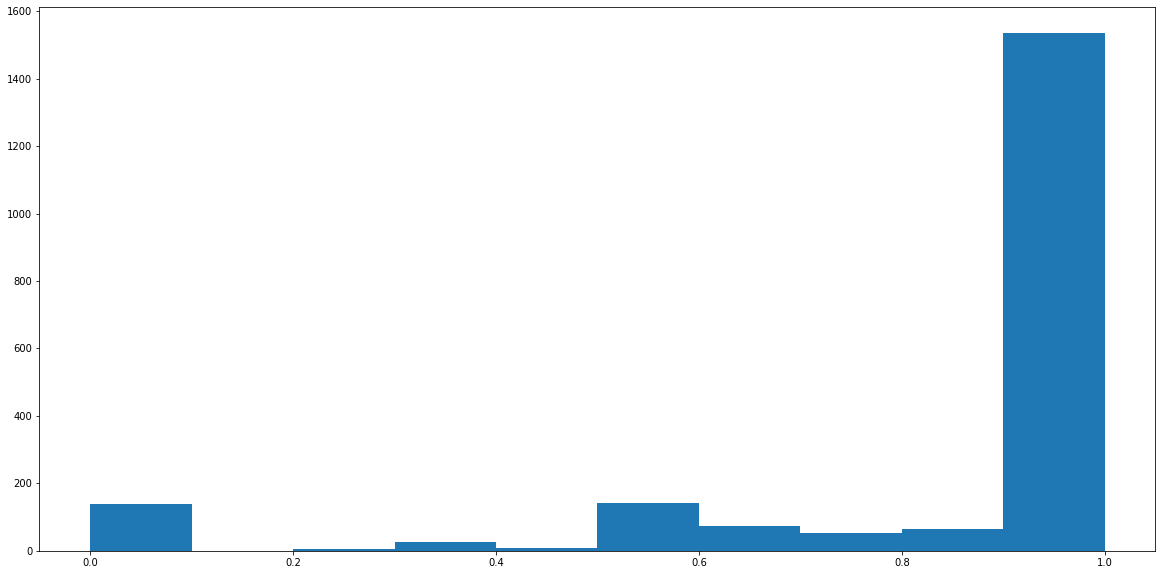

In [47]:
#Plotting recall distribution 
recalls = calculate_recall_distribution(X_test, predictions, y_test)
ids = [item[0] for item in recalls ]
recalls = [item[1] for item in recalls ]
recalls_df = pd.DataFrame(ids , columns=['id'])
recalls_df['recalls']= recalls

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.hist(recalls_df['recalls'])
plt.show()

In [ ]:
#transform both training and testing sets 
training_features = lda.transform(train_vectors)
testing_features = lda.transform(test_vectors)